# S-Learner Tutorial

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadr
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from causalml.inference.meta import BaseSClassifier
from causalml.metrics import plot_qini, plot_gain


In [3]:
data_read = pyreadr.read_r('/Users/pbrendel/projects/multibias/data/df_uc_source.rda')
df = data_read['df_uc_source']

df.head()

,X_bi,X_cont,Y_bi,Y_cont,C1,C2,C3,U
0,0,2.22,0,4.01,0,0,1,1
1,1,2.42,0,4.98,1,0,0,1
2,0,0.98,0,1.37,1,0,1,0
3,0,3.33,0,3.87,1,1,1,1
4,0,4.09,0,4.27,1,1,1,1


In [4]:
Y = df['Y_bi']
T = df['X_bi']
X = df[['C1', 'C2', 'C3', 'U']]

In [5]:
random.seed(123)
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2)

# Obtain CATE in train data

In [6]:
learner = LogisticRegression(penalty=None, solver='lbfgs')
slearner = BaseSClassifier(learner=learner)
slearner.fit(X=X_train, treatment=T_train, y=Y_train)

In [7]:
random.seed(123)
slearner.estimate_ate(
  X=X_train,
  treatment=T_train,
  y=Y_train,
  return_ci=True,
  bootstrap_ci=True,
  bootstrap_size=len(X_train)
)


100%|██████████| 1000/1000 [00:39<00:00, 25.41it/s]


(array([0.10255384]), array([0.09658247]), array([0.10876035]))

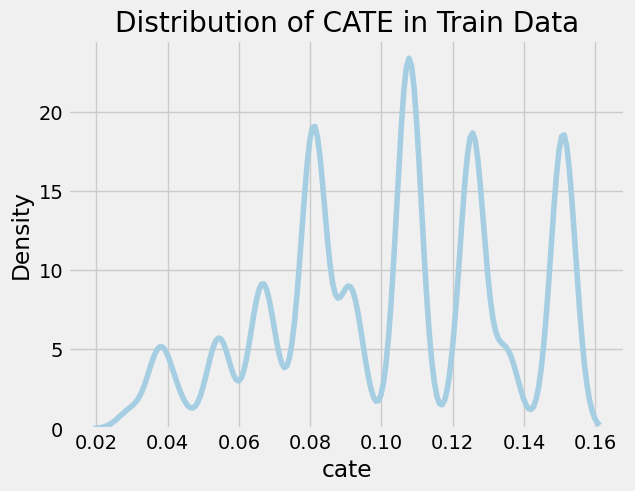

In [8]:
cate_train = slearner.predict(X_train)
sns.kdeplot(data=pd.DataFrame({'cate': cate_train.reshape(-1)}), x="cate")
plt.title("Distribution of CATE in Train Data");


# Compare to CATE in test data

In [9]:
random.seed(123)
slearner.estimate_ate(
  X=X_test,
  treatment=T_test,
  y=Y_test,
  return_ci=True,
  bootstrap_ci=True,
  bootstrap_size=len(X_test)
)

100%|██████████| 1000/1000 [00:23<00:00, 42.23it/s]


(array([0.09888597]), array([0.08746983]), array([0.11045112]))

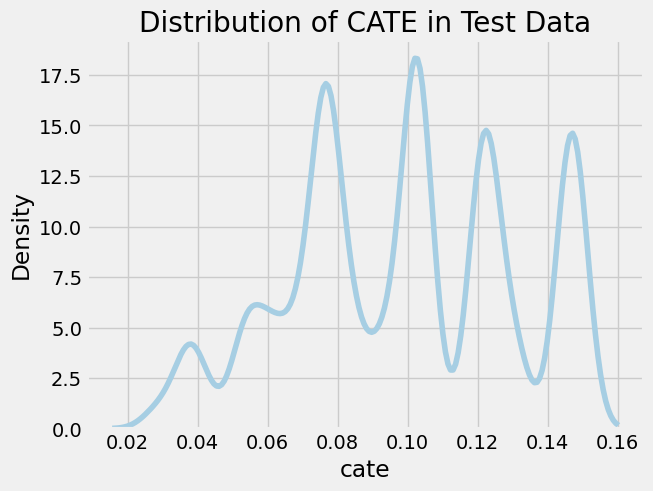

In [10]:
cate_test = slearner.predict(X_test)
sns.kdeplot(data=pd.DataFrame({'cate': cate_test.reshape(-1)}), x="cate")
plt.title("Distribution of CATE in Test Data");

# Assess heterogeneity

In [12]:
df_test = pd.DataFrame({
  'cate': cate_test.reshape(-1),
  'T': T_test,
  'Y': Y_test
}).merge(X, left_index = True, right_index = True)

df_test['cate_group'] = np.where(df_test['cate'] > np.median(df_test['cate']), "High", "Low")

df_test.groupby('cate_group')[['cate', 'T', 'Y', 'C1', 'C2', 'C3', 'U']].agg('mean')

,cate,T,Y,C1,C2,C3,U
cate_group,,,,,,,
High,0.131164,0.412195,0.261653,0.508062,0.00000,0.800076,1.000000
Low,0.077644,0.269773,0.121373,0.502321,0.32847,0.799453,0.158597


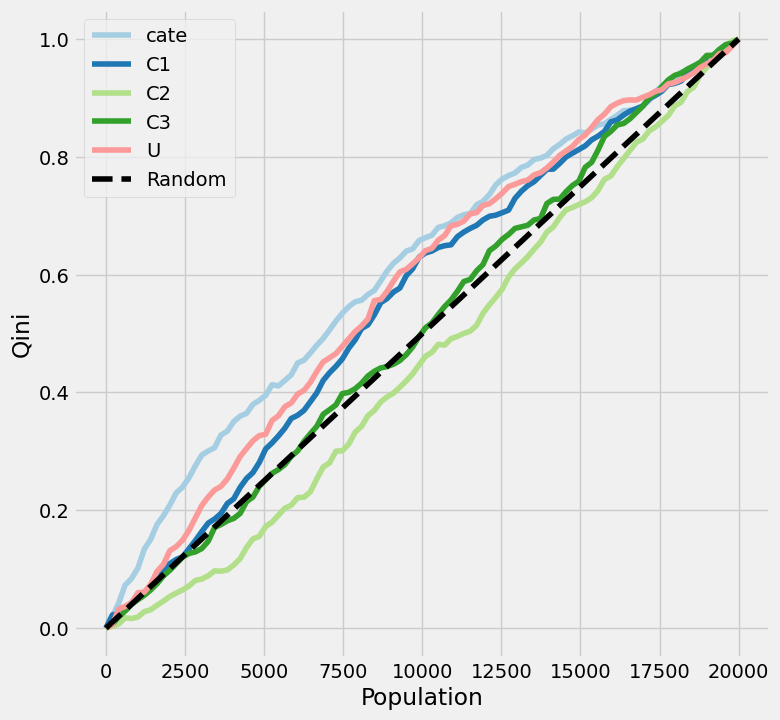

In [28]:
plot_qini(
  df_test.drop('cate_group', axis=1),
  outcome_col='Y',
  treatment_col='T',
  #treatment_effect_col='cate',
  normalize=True
)

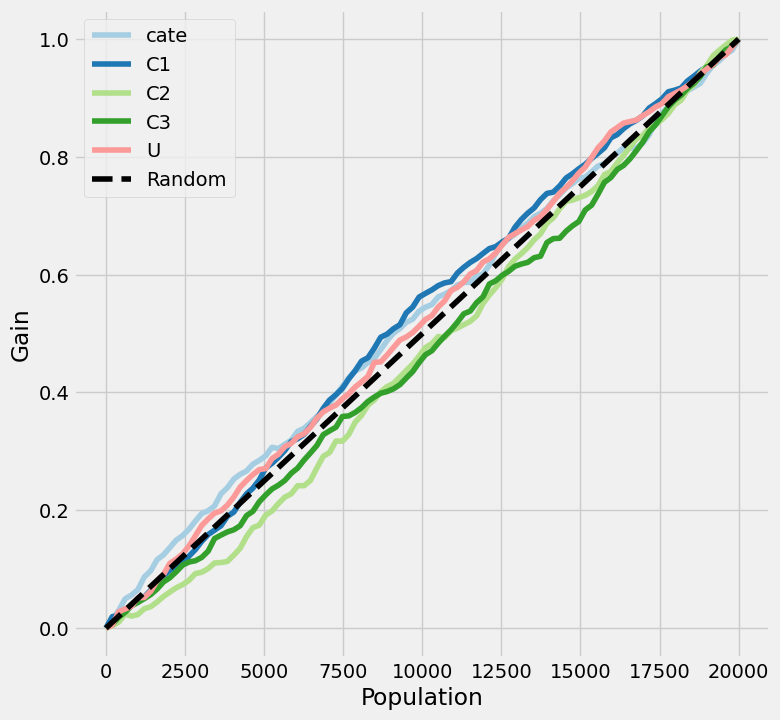

In [ ]:
# plot_gain(
#   df_test.drop('cate_group', axis=1),
#   outcome_col='Y',
#   treatment_col='T',
#   #treatment_effect_col='cate',
#   normalize=True,
#   random_seed=123
# )

In [31]:
slearner.get_importance(
    X=X_test,
    tau=cate_test,
    method='permutation',
    features=X_test.columns.tolist()
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

/Users/pbrendel/anaconda3/envs/env_blockexplorer/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/pbrendel/anaconda3/envs/env_blockexplorer/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/pbrendel/anaconda3/envs/env_blockexplorer/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/pbrendel/anaconda3/envs/env_blockexplorer/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/pbrendel/anaconda3/envs/env_blockexplorer/lib/python3.13/site-packages/sklearn/utils/

{np.int32(1): U     0.884528
 C2    0.701748
 C1    0.288662
 C3    0.084109
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

/Users/pbrendel/anaconda3/envs/env_blockexplorer/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/pbrendel/anaconda3/envs/env_blockexplorer/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/pbrendel/anaconda3/envs/env_blockexplorer/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/pbrendel/anaconda3/envs/env_blockexplorer/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/pbrendel/anaconda3/envs/env_blockexplorer/lib/python3.13/site-packages/sklearn/utils/

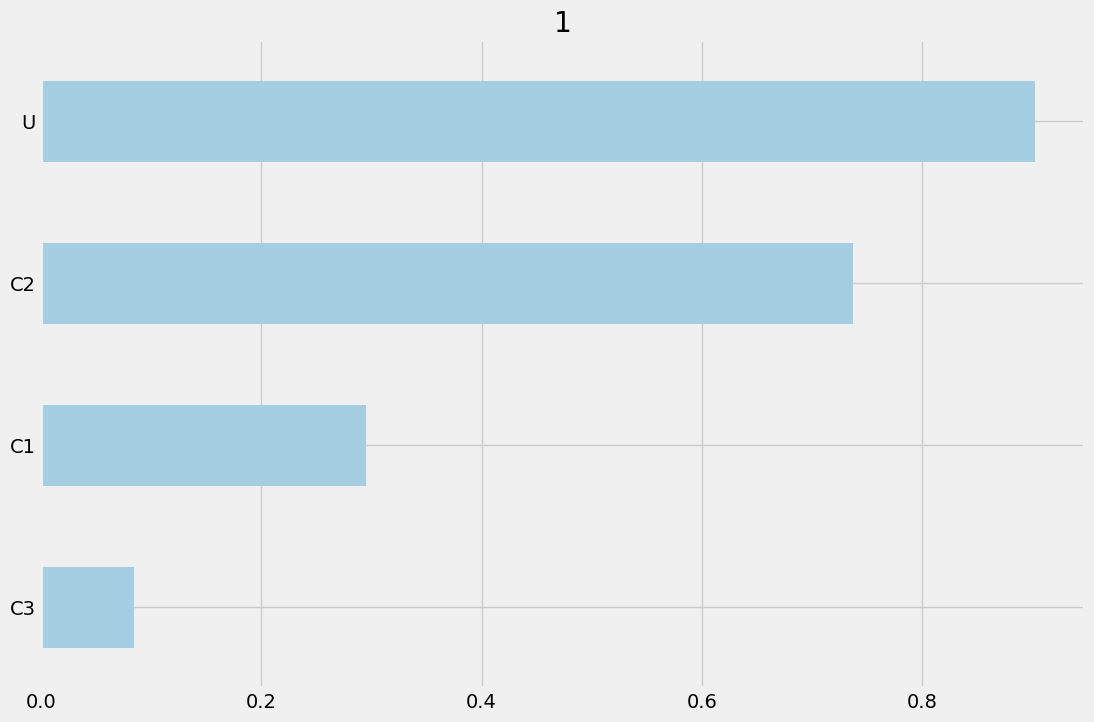

In [ ]:
slearner.plot_importance(
    X=X_test,
    tau=cate_test,
    method='permutation',
    features=X_test.columns.tolist()
)